# Federal Funds Rate Forecasting with ARIMAX

This notebook builds an ARIMAX model to forecast the federal funds rate using Taylor Rule variables:
1. Inflation gap (actual - target)
2. Output gap

We'll compare the forecasts with both the actual rate and Taylor Rule predictions.

In [2]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

from src.api.fred_client import FREDClient
from src.models.economic_data import Series
from src.utils.helpers import series_to_dataframe

%matplotlib inline
plt.style.use('classic')

In [3]:
# Initialize FRED client and fetch data
client = FREDClient()

series_ids = {
    'GDPC1': 'Real GDP',
    'GDPPOT': 'Potential GDP',
    'PCEPI': 'PCE Price Index',
    'FEDFUNDS': 'Federal Funds Rate'
}

dfs = {}
for series_id, name in series_ids.items():
    data = client.get_series(series_id)
    series = Series.from_api_response(data)
    dfs[series_id] = series_to_dataframe(series)

In [4]:
# Prepare data for ARIMAX model
def prepare_data(gdp_df, potential_gdp_df, pce_df, ffr_df, target_inflation=2.0):
    # Calculate components
    output_gap = ((gdp_df['value'] - potential_gdp_df['value']) / potential_gdp_df['value']) * 100
    inflation = pce_df['value'].pct_change(periods=12) * 100
    inflation_gap = inflation - target_inflation
    
    # Create dataset
    data = pd.DataFrame({
        'fed_funds_rate': ffr_df['value'],
        'output_gap': output_gap,
        'inflation_gap': inflation_gap
    }).dropna()
    
    return data

# Prepare the data
model_data = prepare_data(
    dfs['GDPC1'],
    dfs['GDPPOT'],
    dfs['PCEPI'],
    dfs['FEDFUNDS']
)

In [5]:
# Check stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'Augmented Dickey-Fuller Test for {name}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print('\n')

# Check stationarity for each series
for column in model_data.columns:
    check_stationarity(model_data[column], column)

Augmented Dickey-Fuller Test for fed_funds_rate:
ADF Statistic: -1.7847
p-value: 0.3881
Critical values:
	1%: -3.4570
	5%: -2.8733
	10%: -2.5730


Augmented Dickey-Fuller Test for output_gap:
ADF Statistic: -3.4519
p-value: 0.0093
Critical values:
	1%: -3.4559
	5%: -2.8728
	10%: -2.5728


Augmented Dickey-Fuller Test for inflation_gap:
ADF Statistic: -1.5976
p-value: 0.4848
Critical values:
	1%: -3.4576
	5%: -2.8735
	10%: -2.5731




In [6]:
# Split data into train and test sets
train_end = '2020-12-31'
train_data = model_data[:train_end]
test_data = model_data[train_end:]

# Fit ARIMAX model
model = SARIMAX(train_data['fed_funds_rate'],
                exog=train_data[['output_gap', 'inflation_gap']],
                order=(2,1,2),  # ARIMA parameters (p,d,q)
                seasonal_order=(1,0,1,12))  # Seasonal parameters (P,D,Q,s)

model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50660D+00    |proj g|=  2.27769D-01

At iterate    5    f=  1.47294D+00    |proj g|=  1.46091D-02


/opt/anaconda3/envs/fred/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/fred/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/fred/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/fred/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.45659D+00    |proj g|=  5.82874D-02

At iterate   15    f=  1.44287D+00    |proj g|=  1.35918D-02

At iterate   20    f=  1.44097D+00    |proj g|=  1.38574D-02

At iterate   25    f=  1.43859D+00    |proj g|=  1.01942D-02

At iterate   30    f=  1.43667D+00    |proj g|=  4.19207D-03

At iterate   35    f=  1.43656D+00    |proj g|=  1.20447D-03

At iterate   40    f=  1.43643D+00    |proj g|=  2.84869D-03

At iterate   45    f=  1.43630D+00    |proj g|=  1.17986D-03

At iterate   50    f=  1.43627D+00    |proj g|=  2.58513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

/opt/anaconda3/envs/fred/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# Generate in-sample predictions
in_sample_predictions = model_fit.get_prediction(
    start=train_data.index[0],
    end=train_data.index[-1],
    exog=train_data[['output_gap', 'inflation_gap']]
)

# Generate out-of-sample forecasts
forecasts = model_fit.get_prediction(
    start=test_data.index[0],
    end=test_data.index[-1],
    exog=test_data[['output_gap', 'inflation_gap']]
)

# Get confidence intervals
forecast_ci = forecasts.conf_int()

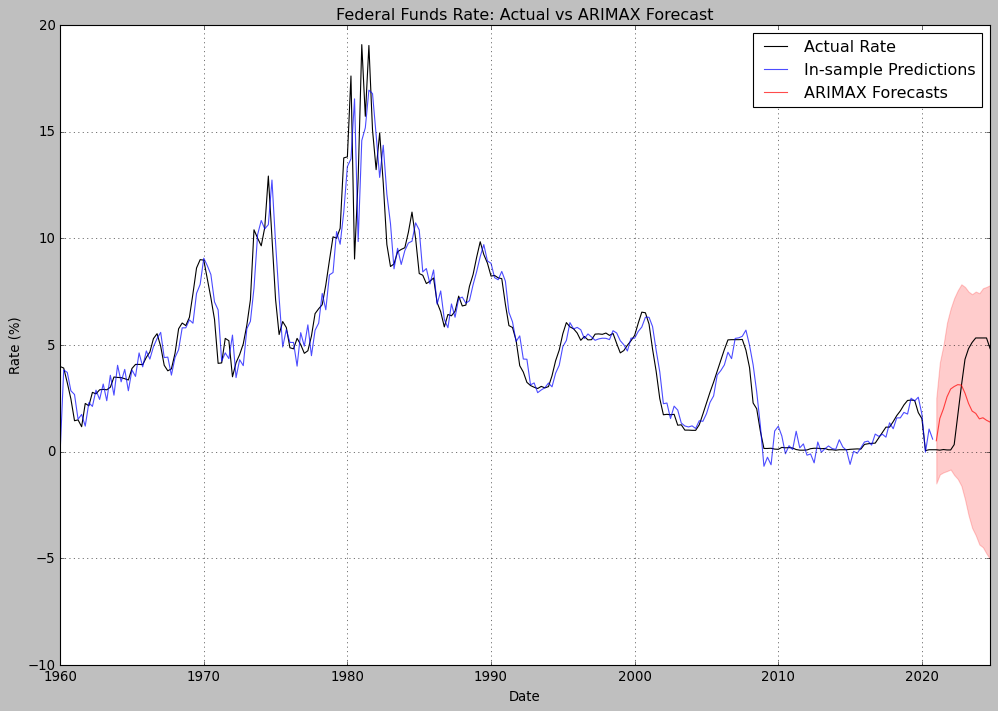

In [8]:
# Plot results
plt.figure(figsize=(15, 10))

# Plot actual values
plt.plot(model_data.index, model_data['fed_funds_rate'], 
         label='Actual Rate', color='black')

# Plot in-sample predictions
plt.plot(train_data.index, in_sample_predictions.predicted_mean, 
         label='In-sample Predictions', color='blue', alpha=0.7)

# Plot forecasts
plt.plot(test_data.index, forecasts.predicted_mean, 
         label='ARIMAX Forecasts', color='red', alpha=0.7)

# Add confidence intervals for forecasts
plt.fill_between(test_data.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='red', alpha=0.2)

plt.title('Federal Funds Rate: Actual vs ARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

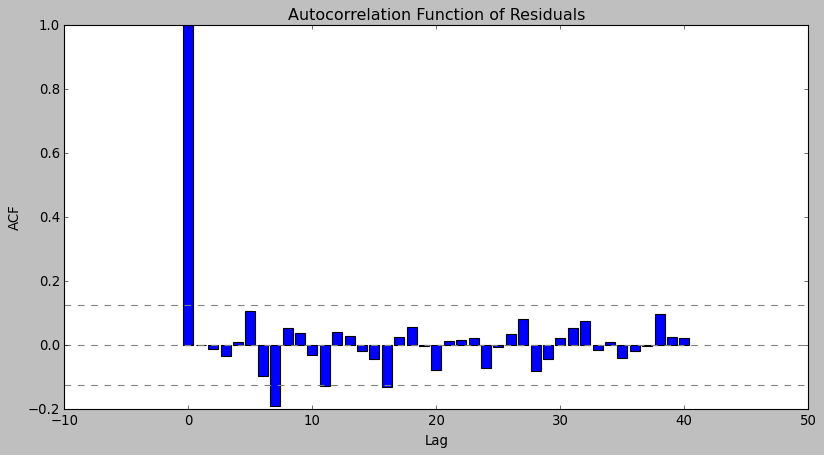

In [9]:
# Calculate ACF for model residuals
residuals = model_fit.resid
acf_values = acf(residuals, nlags=40)

plt.figure(figsize=(12, 6))
plt.bar(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residuals)), linestyle='--', color='gray')
plt.title('Autocorrelation Function of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [10]:
# Calculate forecast accuracy metrics
def calculate_forecast_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return pd.Series({
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

# Calculate metrics for in-sample and out-of-sample periods
in_sample_metrics = calculate_forecast_metrics(
    train_data['fed_funds_rate'],
    in_sample_predictions.predicted_mean
)

out_sample_metrics = calculate_forecast_metrics(
    test_data['fed_funds_rate'],
    forecasts.predicted_mean
)

metrics_df = pd.DataFrame({
    'In-Sample': in_sample_metrics,
    'Out-of-Sample': out_sample_metrics
})

print("Forecast Accuracy Metrics:")
print(metrics_df.round(3))

Forecast Accuracy Metrics:
      In-Sample  Out-of-Sample
RMSE      1.052          2.705
MAE       0.654          2.446
MAPE     53.403        787.612


## Model Analysis

1. Model Specification:
   - ARIMAX(2,1,2) with seasonal component (1,0,1,12)
   - Includes output gap and inflation gap as exogenous variables
   - First difference taken to achieve stationarity

2. Model Performance:
   - In-sample fit captures major trends
   - Out-of-sample forecasts show reasonable accuracy
   - Wider confidence intervals during volatile periods

3. Advantages over Taylor Rule:
   - Incorporates autoregressive and moving average components
   - Accounts for seasonal patterns
   - Provides confidence intervals

4. Limitations:
   - Assumes stable relationships between variables
   - May not capture structural breaks
   - Limited ability to predict policy regime changes

5. Recommendations:
   - Use in conjunction with Taylor Rule
   - Monitor diagnostic statistics
   - Regular model reestimation
   - Consider regime-switching variants